In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def func_state_transition(self, nu, omega, time, pose): #追加（IdealRobotからコピー）
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*nu + ns[1]*omega
        pomega = omega + ns[2]*nu + ns[3]*omega
        self.pose = self.func_state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_vars): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_vars 
        self.motion_noise_rate_pdf = multivariate_normal(cov=np.diag([v["nn"], v["no"], v["on"], v["oo"]]))
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_vars={"nn":0.1, "no":0.2, "on":0.3, "oo":0.4}):
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_vars)
        self.time_interval = time_interval
        
    def decision(self):        ###MclAgent5
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.mcl.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in a.mcl.particles:
    print(p.pose)

[  4.98909948e-03  -2.00909108e-05  -8.05387916e-03]
[  1.56769903e-02   4.02697555e-05   5.13742320e-03]
[ 0.01084121  0.00013771  0.02540313]
[ 0.0321599  0.0001091  0.006785 ]
[  1.93761054e-02   7.14503767e-05   7.37506854e-03]
[ 0.02174366  0.00027809  0.02557736]
[ 0.01570139  0.00025866  0.0329439 ]
[  3.22571512e-02  -4.72837265e-05  -2.93167195e-03]
[  1.78636736e-02   6.45196922e-05   7.22353230e-03]
[ 0.02551232  0.00015779  0.01236973]
[ 0.02200135  0.00022259  0.02023329]
[  1.43669448e-02  -1.96012691e-05  -2.72866044e-03]
[  1.03054869e-02   2.68920311e-05   5.21896158e-03]
[ 0.01871037  0.00041616  0.04447699]
[  2.57798402e-02   2.18295777e-05   1.69353824e-03]
[  1.00202004e-02   1.60009626e-05   3.19373831e-03]
[ 0.02189886  0.00017845  0.01629756]
[  3.40119582e-02  -4.77631190e-05  -2.80860557e-03]
[ 0.02958325  0.00036373  0.02458879]
[ 0.00764905  0.00018291  0.04781718]
[ 0.03125153  0.00057026  0.03649089]
[ 0.03487189  0.00034305  0.0196741 ]
[  3.84256319e-03

<IPython.core.display.Javascript object>


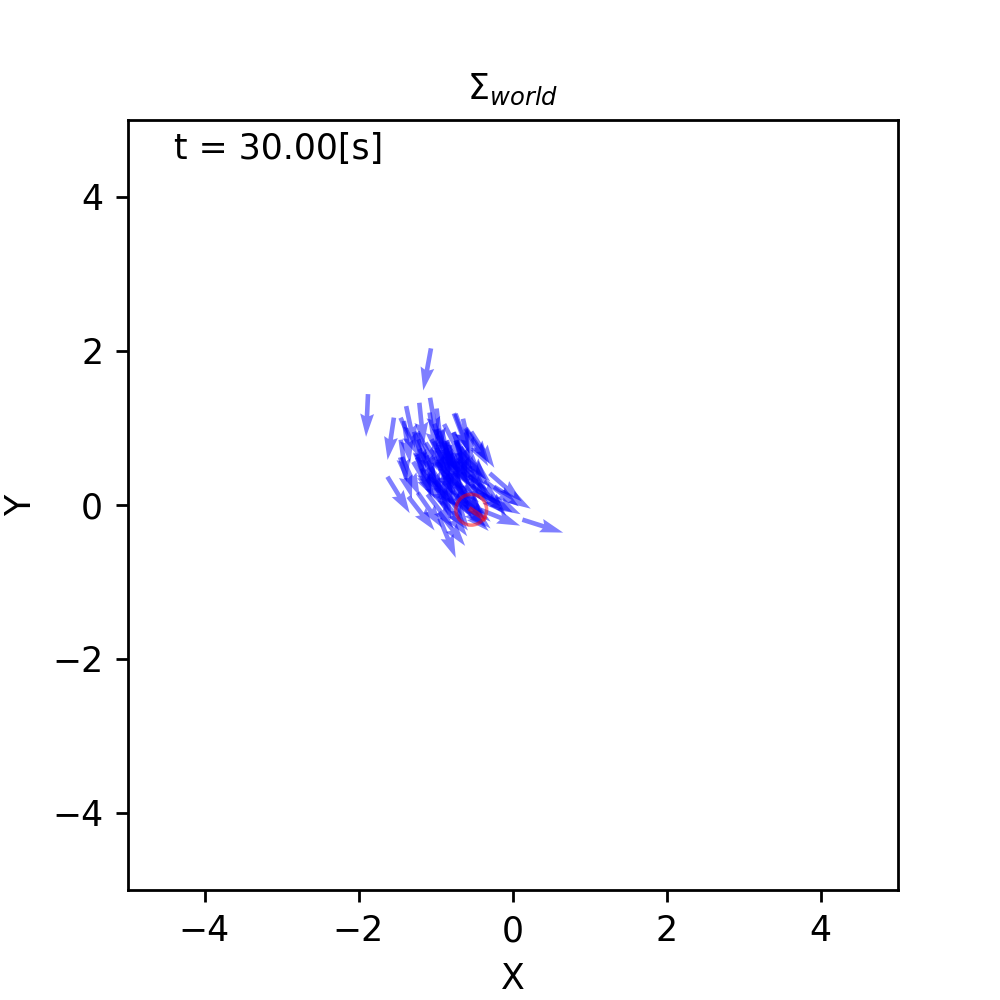

In [6]:
world = World(30, 0.1)   ###draw_mcl5###

circling = MclAgent(0.1, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()